# Deep learning from scratch: Cancer malignancy detection as an example


**This notebook holds the Python code used for building a neural network from scratch using Python**

**During this tutorial we are going to:**
- Create a neural network from scratch in Python. 
- Train the network using the gradient descent algorithm (will see what a gradient descent is in a bit).
- We wil use the Wisconsin Cancer Data-set to predict if a tumor is benign or malignant based on 9 different features.
- Explore deeply how back-propagation (the building block of pretty much all the DL algorithms) work.
- Review some optimization techniques that are used during training a neural network. 

## Python packages needed for this tutorial

In [65]:
import numpy as np                              # linear algebra on python arrays
import matplotlib.pyplot as plt                 # data vizulisation
import pandas as pd                             # data loading and preparation
from sklearn import preprocessing               # statistics on data
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from sklearn.metrics import confusion_matrix    # performance metric (kaggle winner)
import itertools

np.set_printoptions(threshold=np.inf)

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Confusion matrix you said?
Refer to  [this excellent article](https://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/) to learn more about confusion matrices from which  here is the eesential part:<br/>
A confusion matrix is a metric that is used to evaluate the performance of a classification model (or "classifier") on a set of test data for which the true values are known. 
For example (taken from the above article), let us consider a confusion matrix for a binary classifier (though it can easily be extended to the case of more than two classes):

|  n=165         | predicted NO     | predicted YES     |     |
|----------------|------------------|-------------------|-----|
| **actual NO**  | **TN**=50        | **FP**=10         | <span style="color:red">60</span>    |
| **actual YES** | **FN**=5         | **TP**=100        | <span style="color:green">105</span> |
| <i></i>        | <span style="color:blue">55</span>   | <span style="color:blue">110</span>  |

* **Accuracy**: Overall, how often is the classifier correct?<br />
    * (TP+TN)/total = (100+50)/165 = 0.91
* **Misclassification Rate**: Overall, how often is it wrong?
    * (FP+FN)/total = (10+5)/165 = 0.09
    * equivalent to 1 minus Accuracy
    * also known as "Error Rate"
* **True Positive Rate**: When it's actually yes, how often does it predict yes?
    * TP/actual yes = 100/105 = 0.95
    * also known as "Sensitivity" or "Recall"
* **False Positive Rate**: When it's actually no, how often does it predict yes?
    * FP/actual no = 10/60 = 0.17
* **True Negative Rate**: When it's actually no, how often does it predict no?
    * TN/actual no = 50/60 = 0.83
    * equivalent to 1 minus False Positive Rate
    * also known as "Specificity"
* **Precision**: When it predicts yes, how often is it correct?
    * TP/predicted yes = 100/110 = 0.91
* **Prevalence**: How often does the yes condition actually occur in our sample?
    * actual yes/total = 105/165 = 0.64

In [67]:
def plot_confusion_matrix(a,b,t):
    cf =confusion_matrix(a,b)
    plt.imshow(cf,cmap=plt.cm.Blues,interpolation='nearest')
    plt.colorbar()
    plt.title(t)
    plt.xlabel('predicted')
    plt.ylabel('actual')
    tick_marks = np.arange(len(set(a))) # length of classes
    class_labels = ['0','1']
    plt.xticks(tick_marks,class_labels)
    plt.yticks(tick_marks,class_labels)
    thresh = cf.max() / 2.
    for i,j in itertools.product(range(cf.shape[0]),range(cf.shape[1])):
        plt.text(j,i,format(cf[i,j],'d'),horizontalalignment='center',color='white' if cf[i,j] >thresh else 'black')
    plt.show();

### Let us build a neural network model with 2 layers
We are going to build a neural network from scratch in Python. Train it using the gradient descent algorithm.
Apply that basic network to The Wisconsin Cancer Data-set. Predict if a tumor is benign or malignant, based on 9 different features.
We are going to explore the back-propagation in depth and we will try to understand how things work inside a network.
Our network has 2 layers + 1 input layer. The first layer (the input) has 9 neurons since the data has 9 features, the second (the only hidden layer) has 15 neurons and the final one (the output layer) has 1 layer since it is a binary classification.

In [71]:
class HealNet:
    
    def __init__(self, x, y):
        self.X     = x
        self.Y     = y
        self.Yh    = np.zeros((1,self.Y.shape[1])) 
        self.dims  = [9, 15, 1] 
        self.param = {}
        self.ch    = {}
        self.grad  = {}
        self.loss  = []
        self.lr    = 0.003
        self.sam   = self.Y.shape[1]
        self.threshold=0.5

    def init_params(self):    
        np.random.seed(1)
        self.param['W1'] = np.random.randn(self.dims[1], self.dims[0]) / np.sqrt(self.dims[0]) 
        self.param['b1'] = np.zeros((self.dims[1], 1))        
        self.param['W2'] = np.random.randn(self.dims[2], self.dims[1]) / np.sqrt(self.dims[1]) 
        self.param['b2'] = np.zeros((self.dims[2], 1))                
        return 

    def forward(self):    
        Z1 = self.param['W1'].dot(self.X) + self.param['b1'] 
        A1 = Relu(Z1)
        self.ch['Z1'],self.ch['A1']=Z1,A1
        
        Z2 = self.param['W2'].dot(A1) + self.param['b2']  
        A2 = Sigmoid(Z2)
        self.ch['Z2'],self.ch['A2']=Z2,A2

        self.Yh=A2
        loss=self.compute_loss(A2)
        return self.Yh, loss

    def compute_loss(self, Yh):
        loss = (1./self.sam) * (-np.dot(self.Y,np.log(Yh).T) - np.dot(1-self.Y, np.log(1-Yh).T))    
        return loss

    def backward(self):
        dLoss_Yh = - (np.divide(self.Y, self.Yh ) - np.divide(1 - self.Y, 1 - self.Yh))    
        
        dLoss_Z2 = dLoss_Yh * dSigmoid(self.ch['Z2'])    
        dLoss_A1 = np.dot(self.param["W2"].T,dLoss_Z2)
        dLoss_W2 = 1./self.ch['A1'].shape[1] * np.dot(dLoss_Z2,self.ch['A1'].T)
        dLoss_b2 = 1./self.ch['A1'].shape[1] * np.dot(dLoss_Z2, np.ones([dLoss_Z2.shape[1],1])) 
                            
        dLoss_Z1 = dLoss_A1 * dRelu(self.ch['Z1'])        
        dLoss_A0 = np.dot(self.param["W1"].T,dLoss_Z1)
        dLoss_W1 = 1./self.X.shape[1] * np.dot(dLoss_Z1,self.X.T)
        dLoss_b1 = 1./self.X.shape[1] * np.dot(dLoss_Z1, np.ones([dLoss_Z1.shape[1],1]))  
        
        self.param["W1"] = self.param["W1"] - self.lr * dLoss_W1
        self.param["b1"] = self.param["b1"] - self.lr * dLoss_b1
        self.param["W2"] = self.param["W2"] - self.lr * dLoss_W2
        self.param["b2"] = self.param["b2"] - self.lr * dLoss_b2
        
        return


    def predict(self, x, y):  
        self.X = x
        self.Y = y
        comp   = np.zeros((1,x.shape[1]))
        pred, loss= self.forward()    
    
        for i in range(0, pred.shape[1]):
            if pred[0,i] > self.threshold:
                comp[0,i] = 1
            else:
                comp[0,i] = 0
    
        print("Acc: " + str(np.sum((comp == y)/x.shape[1])))
        
        return comp
    
    def train(self, X, Y, iter = 3000):
        np.random.seed(1)                         
    
        self.init_params()
    
        for i in range(0, iter):
            Yh, loss=self.forward()
            self.backward()
        
            if i % 500 == 0:
                print ("Cost after iteration %i: %f" %(i, loss))
                self.loss.append(loss)

        plt.plot(np.squeeze(self.loss))
        plt.ylabel('Loss')
        plt.xlabel('Iter')
        plt.title("Learning Rate =" + str(self.lr))
        plt.show()
    
        return

### Biases
A neural network is a good function approximator. In the case of classification, we are interested in approximating a decision boundary in form of a hyperplane. In case of regression, we want to approximate a function that defines a relationship between X and y.

Imagine, we have a function 𝑓(𝑥)=𝑎.𝑥. Now, obviously, 𝑓(𝑥)doesn’t have a constant term (the constant term in neural network and ML is called bias). Therefore, 𝑓(𝑥)always passes through origin (0,0). But, what if the line that we are modeling doesn’t pass through origin, rather it intersect with the x-axis at 𝑐; i.e. (0,𝑏). The bias term is added to give this capability to our function. So in this case, 𝑓(𝑥)=𝑎.𝑥+𝑏 and we hope that after training, the bias term 𝑏 will be close to 𝑐 rather than forcing it to be zero.

### Activation functions
* sigmoid $ f(x) = \dfrac{1}{1+e^{-x}} $
![sg](sigmoid.png)
* tanh $ f(x) = \dfrac{2}{1+e^{-2x}} - 1 $
![th](tanh.png)
* relu $ f(x) = max(0,x) $
![rl](relu.jpeg)
* leaky-relu
![lrl](lrelu.png)

Only sigmoid in the output layer why?

In [72]:
def Sigmoid(Z):
    return 1/(1+np.exp(-Z))

def Relu(Z):
    return np.maximum(0,Z)

def dRelu2(dZ, Z):    
    dZ[Z <= 0] = 0    
    return dZ

def dRelu(x):
    x[x<=0] = 0
    x[x>0] = 1
    return x

def dSigmoid(Z):
    s = 1/(1+np.exp(-Z))
    dZ = s * (1-s)
    return dZ

### Loss function
We use the cross entropy loss function
$ −(ylog(\hat{y})+(1−y)log(1−\hat{y})) $.


### The Wisconsin Dataset
We use the data from this link <a href="https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/breast-cancer-wisconsin.data" target="_blank">Wisconsin Cancer Dataset</a>.<br>
One of the studies linked to the data-set: O. L. Mangasarian and W. H. Wolberg: “Cancer diagnosis via linear programming”, SIAM News, Volume 23, Number 5, September 1990, pp 1 & 18.

In [ ]:
!curl https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/breast-cancer-wisconsin.data --output wisconsin-cancer-dataset.csv

**Prepare the data**
* We store the data in .csv format in the machine.
* We read the data using Pandas read_csv function.
* Then we proceed to clean and prepare the data.

In [73]:
df = pd.read_csv('wisconsin-cancer-dataset.csv',header=None)
df = df[~df[6].isin(['?'])]
df = df.astype(float)
df.iloc[:,10].replace(2, 0,inplace=True)
df.iloc[:,10].replace(4, 1,inplace=True)

df.head(3)
scaled_df=df
names = df.columns[0:10]
scaler = MinMaxScaler() 
scaled_df = scaler.fit_transform(df.iloc[:,0:10]) 
scaled_df = pd.DataFrame(scaled_df, columns=names)
df.head(10)

,0,1,2,3,4,5,6,7,8,9,10
0,1000025.0,5.0,1.0,1.0,1.0,2.0,1.0,3.0,1.0,1.0,0.0
1,1002945.0,5.0,4.0,4.0,5.0,7.0,10.0,3.0,2.0,1.0,0.0
2,1015425.0,3.0,1.0,1.0,1.0,2.0,2.0,3.0,1.0,1.0,0.0
3,1016277.0,6.0,8.0,8.0,1.0,3.0,4.0,3.0,7.0,1.0,0.0
4,1017023.0,4.0,1.0,1.0,3.0,2.0,1.0,3.0,1.0,1.0,0.0
5,1017122.0,8.0,10.0,10.0,8.0,7.0,10.0,9.0,7.0,1.0,1.0
6,1018099.0,1.0,1.0,1.0,1.0,2.0,10.0,3.0,1.0,1.0,0.0
7,1018561.0,2.0,1.0,2.0,1.0,2.0,1.0,3.0,1.0,1.0,0.0
8,1033078.0,2.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,5.0,0.0
9,1033078.0,4.0,2.0,1.0,1.0,2.0,1.0,2.0,1.0,1.0,0.0


Notice that we normalized the data. Normalizing the data means preparing it in a way that is easier for the network to digest. We are helping the network converge easier and faster to that minima we are looking for. Typically, neural networks respond well to numerical data set in the 0 to 1 range, and also to data that has a mean of 0 and a standard deviation of 1.

In [60]:
scaled_df.head(10)

,0,1,2,3,4,5,6,7,8,9
0,0.069946,0.444444,0.000000,0.000000,0.000000,0.111111,0.000000,0.222222,0.000000,0.000000
1,0.070164,0.444444,0.333333,0.333333,0.444444,0.666667,1.000000,0.222222,0.111111,0.000000
2,0.071096,0.222222,0.000000,0.000000,0.000000,0.111111,0.111111,0.222222,0.000000,0.000000
3,0.071160,0.555556,0.777778,0.777778,0.000000,0.222222,0.333333,0.222222,0.666667,0.000000
4,0.071216,0.333333,0.000000,0.000000,0.222222,0.111111,0.000000,0.222222,0.000000,0.000000
5,0.071223,0.777778,1.000000,1.000000,0.777778,0.666667,1.000000,0.888889,0.666667,0.000000
6,0.071296,0.000000,0.000000,0.000000,0.000000,0.111111,1.000000,0.222222,0.000000,0.000000
7,0.071331,0.111111,0.000000,0.111111,0.000000,0.111111,0.000000,0.222222,0.000000,0.000000
8,0.072415,0.111111,0.000000,0.000000,0.000000,0.111111,0.000000,0.000000,0.000000,0.444444
9,0.072415,0.333333,0.111111,0.000000,0.000000,0.111111,0.000000,0.111111,0.000000,0.000000


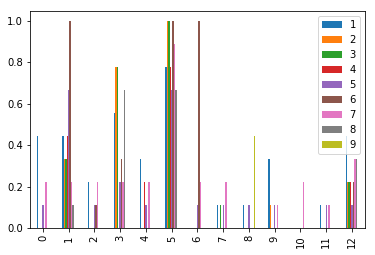

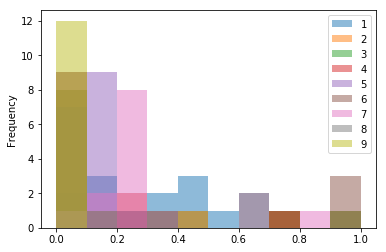

In [80]:
scaled_df.iloc[0:13,1:11].plot.bar();
scaled_df.iloc[0:13,1:11].plot.hist(alpha=0.5)

**Split the data**<br>
The deep learning practitioner typically takes into account three kinds of data-sets:

* **Training set**: the data you use to train the network. It contains the input features and the target labels.
* **Validation set**: a separate, different batch of data, which should ideally come from the same distribution than the training set. You will use it to verify the quality of the training. The validation set has as well target labels.
* **Test set**: another separate batch of data, used to test the network with fresh related data that ideally comes from the same distribution than the validation set. Typically, the test set doesn’t come with target labels.

We will not have one in this very basic example.
There are 699 rows in total, belonging to 699 patients
The first column is an ID that identifies each patient.
The following 9 columns are features that express different types of information connected to the detected tumors. They represent data related to: Clump Thickness, Uniformity of Cell Size, Uniformity of Cell Shape, Marginal Adhesion, Single Epithelial Cell Size, Bare Nuclei, Bland Chromatin, Normal Nucleoli and Mitoses.
The last column is the class of the tumor and it has two possible values: 2 means that the tumor was found to be benign. 4 means that it was found to be malignant.
We are told as well that there are a few rows that contain missing data. The missing data is represented in the data-set with the ? character.
Out of the 699 patients in the dataset, the class distribution is: Benign: 458 (65.5%) and Malignant: 241 (34.5%).

In [74]:
x   = scaled_df.iloc[0:500,1:10].values.transpose()
y   = df.iloc[0:500,10:].values.transpose()

xval= scaled_df.iloc[501:683,1:10].values.transpose()
yval= df.iloc[501:683,10:].values.transpose()

print(df.shape, x.shape, y.shape, xval.shape, yval.shape)

(683, 11) (9, 500) (1, 500) (9, 182) (1, 182)


### Let us play and train our model
We create a model and train it right away with a learning rate of 0.07.

In [75]:
nn      = HealNet(x,y)
nn.lr   = 0.07
nn.dims = [9, 15, 1]

Cost after iteration 0: 0.673967
Cost after iteration 500: 0.122093
Cost after iteration 1000: 0.108469
Cost after iteration 1500: 0.103673
Cost after iteration 2000: 0.100911
Cost after iteration 2500: 0.099047
Cost after iteration 3000: 0.097530
Cost after iteration 3500: 0.096368
Cost after iteration 4000: 0.095480
Cost after iteration 4500: 0.094744
Cost after iteration 5000: 0.094015
Cost after iteration 5500: 0.093277
Cost after iteration 6000: 0.092611
Cost after iteration 6500: 0.091953
Cost after iteration 7000: 0.091279
Cost after iteration 7500: 0.090472
Cost after iteration 8000: 0.089574
Cost after iteration 8500: 0.088575
Cost after iteration 9000: 0.087426
Cost after iteration 9500: 0.086303
Cost after iteration 10000: 0.085122
Cost after iteration 10500: 0.084010
Cost after iteration 11000: 0.083025
Cost after iteration 11500: 0.082001
Cost after iteration 12000: 0.080948
Cost after iteration 12500: 0.079923
Cost after iteration 13000: 0.078909
Cost after iteration 1350

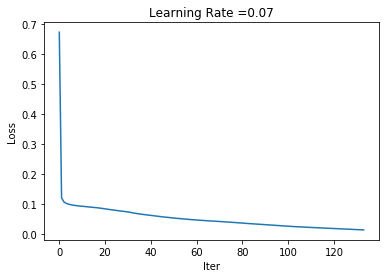

In [76]:
nn.train(x, y, iter = 67000)

To estimate the quality of the training of your network, it is useful to compare the performance of your training and validation sets:

If the loss value achieved on the validation set improves and then starts to get worse, the network is **over-fitting**, meaning the network has learnt a function that fits very well the training data, yet does not generalize well enough to the validation set.
The opposite of over-fitting is **under-fitting**, when the training performance of the network is not good enough and we obtain loss values that are too high in both the training and validation sets (and the training loss is worse than the validation loss, for example).
Ideally you want to get similar performance in both data-sets.
When we have over-fitting, we can apply regularization. Regularization is a technique that applies changes to the optimization algorithm that allow the network to generalize better. Regularization techniques include Dropout, L1 and L2 regularization, early stopping and data augmentation techniques.
In general, realize that success with the validation set is your real target. Having the network perform fantastically well with the training data serves no purpose if it fails to perform well with new data it hasn’t seen before.

So your real target is to reach a good loss value and achieve good accuracy with your validation set.

To get there, over-fitting is one of the most important issues we need to prevent, and that’s why regularization is so important. Let’s quickly and briefly recap 4 widely used regularization techniques.

* **Dropout**: During each training pass, we randomly disable some of the hidden units of our network. This prevents the network from putting too much emphasis on any specific weight and helps the network generalize better. It is as if we were running the data through different network architectures and then averaging their impact, which helps prevent over-fitting.

* **L1 and L2**: We add extra terms to the cost function that penalize the network when weights become too large. These techniques encourage the network to find a good balance between the loss value and the scale of the weights.

* **Early stopping**: Over-fitting can be a consequence of training for too long. If we monitor our validation error, we can stop the training process when the validation error stops improving.

* **Data augmentation**: Typically, more training data means a better network performance, but obtaining more data is not always possible. Instead, we can augment the existing data by artificially creating variations of it. For example, in the case of images, we can apply rotations, translations, cropping and other techniques to produce new variations of them.

### Now let us check and do some predictions

In [78]:
pred_train = nn.predict(x, y)
pred_test  = nn.predict(xval, yval)

Acc: 0.9960000000000003
Acc: 0.9945054945054945


Acc: 1.0000000000000004


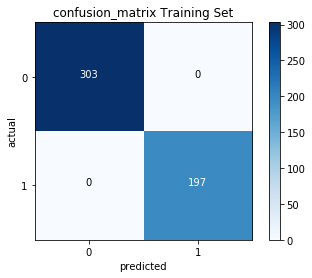

Acc: 0.9945054945054945


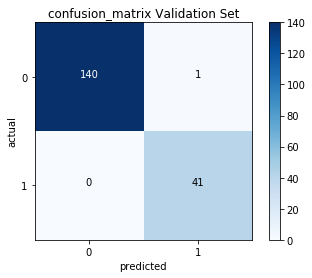

In [79]:
nn.threshold = 0.5
nn.X,nn.Y    = x, y 
target       = np.around(np.squeeze(y), decimals=0).astype(np.int)
predicted    = np.around(np.squeeze(nn.predict(x,y)), decimals=0).astype(np.int)
plot_confusion_matrix(target,predicted,'confusion_matrix Training Set')

nn.X,nn.Y    = xval, yval 
target       = np.around(np.squeeze(yval), decimals=0).astype(np.int)
predicted    = np.around(np.squeeze(nn.predict(xval,yval)), decimals=0).astype(np.int)
plot_confusion_matrix(target,predicted,'confusion_matrix Validation Set')

Acc: 0.9960000000000003


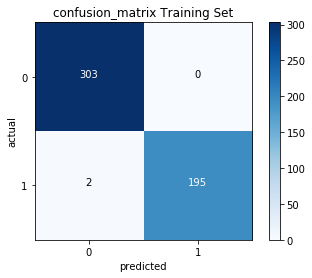

Acc: 0.9945054945054945


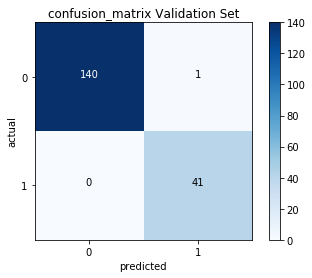

In [77]:
nn.threshold=0.7

nn.X,nn.Y = x, y 
target    = np.around(np.squeeze(y), decimals=0).astype(np.int)
predicted = np.around(np.squeeze(nn.predict(x,y)), decimals=0).astype(np.int)
plot_confusion_matrix(target,predicted,'confusion_matrix Training Set')

nn.X,nn.Y = xval, yval 
target    = np.around(np.squeeze(yval), decimals=0).astype(np.int)
predicted = np.around(np.squeeze(nn.predict(xval,yval)), decimals=0).astype(np.int)
plot_confusion_matrix(target,predicted,'confusion_matrix Validation Set')


Acc: 0.9840000000000003


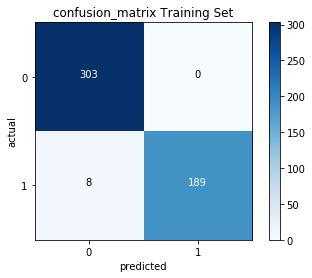

Acc: 0.9945054945054945


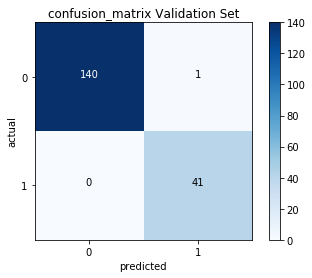

In [61]:
nn.threshold=0.9

nn.X,nn.Y=x, y 
target=np.around(np.squeeze(y), decimals=0).astype(np.int)
predicted=np.around(np.squeeze(nn.predict(x,y)), decimals=0).astype(np.int)
plot_confusion_matrix(target,predicted,'confusion_matrix Training Set')

nn.X,nn.Y=xval, yval 
target=np.around(np.squeeze(yval), decimals=0).astype(np.int)
predicted=np.around(np.squeeze(nn.predict(xval,yval)), decimals=0).astype(np.int)
plot_confusion_matrix(target,predicted,'confusion_matrix Validation Set')

In [ ]:
nn.X,nn.Y=xval, yval 
yvalh, loss = nn.forward()
print("\ny  = ",np.around(yval[:,0:50,], decimals=0).astype(np.int))       
print("\nyh =",np.around(yvalh[:,0:50,], decimals=0).astype(np.int),"\n")

## Optimizations
Although we have done quite well, considering that we are using a basic network without regularization, it is typical for things to get much harder when you are dealing with more complex data.

Often, the loss landscape gets very complex and it’s easier to fall in the wrong local minima or fail to converge to a good enough loss.

Also, depending on the initial conditions of the network, we may converge to a good minima or we may get stuck at a plateau somewhere and fail to get out of it. It’s useful at this stage to picture again our initial animation.

**Back propagation**<br/>
The key optimization is the one we need to apply to back-propagations. We need to avoid probems like **local minmas**
have a look at this landscape of loss function taken from [ideami.com](www.ideami.com):
<hr/>

![bp](loss-landscape-deep-learning-animation.gif)

<hr/>

**Techniques of back propagation**<br/>

**SGDR, Stochastic Gradient Descent with Restarts**: Resetting our learning rate every x iterations. This can help us get out of plateaus or local minima that are not low enough, if we get stuck in one of them. A typical process is to start with a high learning rate. You then decrease it gradually at each mini batch. After x number of Epochs you reset it back to its initial high value and the same process repeats again. The concept is that moving gradually from a high rate to a lower one makes sense because we first quickly move down from the high points of the landscape (initial high loss value) and then move slower to prevent bypassing the minima of the landscape (low loss value areas). But if we get stuck at some plateau or a valley that is not low enough, restarting our rate to a high value every x iterations will help us jump out of that situation and continue exploring the landscape.
1 Cycle Policy: A way of dynamically changing the learning rate proposed by Leslie N. Smith, in which we begin with a low rate value and gradually increase it until we reach a maximum. Then, we proceed to gradually decrease it till the end of the process. The initial gradual increase allows us to explore large areas of the loss landscape, increasing our chances of reaching a low area that is not bumpy; in the second part of the cycle, we settle in the low, flat area we have reached.

**Momentum**: A variation of stochastic gradient descent that helps accelerate the path through the loss landscape while keeping the overall direction controlled. Recall that SGD can be noisy. Momentum averages the changes in the path, smooths that path and accelerates the movement towards the goal.

**Adaptive learning rates**: Methods that calculate and use different learning rates for different parameters of the network.

**AdaGrad (Adaptive Gradient Algorithm)**: 
Connecting with the previous point, AdaGrad is a variation of SGD that instead of using a single learning rate for all the parameters, uses a different rate for each parameter.

**Root Mean Square Propagation (RMSProp)**: 
Like Adagrad, RMSProp uses different learning rates for each parameter, and adapts those rates depending on the average of how fast they are changing (this helps when dealing with noisy contexts).

**Adam**: It combines some aspects of RMSprop and SGDR with momentum. Like RMSprop, it uses squared gradients to scale the learning rate, and it also uses the average of the gradient to make use of momentum.
